# MODTRAN File Processing
 
This notebook forms part of a series on computational optical radiometry.  The notebooks can be downloaded from \cite{Willers2016githubCompRadioNotebooks08}. These notebooks are constantly revised and updated, please revisit from time to time.  
 
 The date of this document and module versions used in this document are given at the end of the file.  
 Feedback is appreciated: neliswillers at gmail dot com.
 

## Overview

 The pyradi library has a module to handle \ac{MODTRAN} files.  The module currently has only one function: to read \ac{MODTRAN} tape7 files in an intelligent manner.  The function is `rymodtran.loadtape7`.


In [1]:
# to set up the Python environment.
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import pyradi.ryfiles as ryfiles
import pyradi.ryplot as ryplot
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

import matplotlib as mpl
mpl.rc("savefig", dpi=300)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

# import pandas as pd
# pd.set_option('display.max_columns', 80)
# pd.set_option('display.width', 100)
# pd.set_option('display.max_colwidth', 150)


## Tape7 Units


The `tape7` format, and tools to read the files are given in `08-ModtranFileProcessing.ipynb`.  Please consult the notebook for more details.  Here is a summary of the units used  in  `tape7` files.
The format differs depending on the type of \ac{MODTRAN} run.

\ac{MODTRAN} does calculations in the wavenumer domain with units \si{\centi\metre^{-1}}. 
In most (all?) `tape7` files the wavenumber is the first column in the file.  The column header is `FREQ`.

Depending on the specific `tape5` parameters, the transmittance and optical depth may be in different columns, often with different headers.  Column headers can be `TOT TRANS` or `COMBIN_TRANS`. The file formats are described below.

Path radiance is only present in some file formats.  Radiance units in tape7 files are \si{\watt\per(\centi\metre\squared.\steradian.\centi\metre^{-1})}.
The first part of the denominator represents areal density in \si{\centi\metre\squared}, hence the density must be converted to \si{\metre\squared}.
The second part of the denominator represents solid angle and no further conversion is necessary.
The third part of the denominator represents the spectral density \si{\per\centi\metre^{-1}} and this can be used as-is or it can be converted to a spectral density in the wavelength domain with units \si{\watt\per(\centi\metre\squared.\steradian.\micro\metre)}. 
Recall the relationship between wavelength, $\lambda$, and wavenumber, $\tilde{\nu}$:
$\lambda=10^4/\tilde{\nu}$,  and for spectral density 
$dL_\lambda
=dL_{\tilde{\nu}} 10^4/\lambda^2
=dL_{\tilde{\nu}} \tilde{\nu}^2/10^4
$





## Loading Tape7 Files

This function reads in the tape7 file from \ac{MODTRAN}  \cite{modtran2009} code, that is used to model the propagation of the electromagnetic radiation through the atmosphere. tape7 is a primary file that contains all the spectral results of the \ac{MODTRAN} run. The header information in the tape7 file contains portions of the tape5 information that is ignored here. The header section in tape7 is followed by a list of spectral samples with corresponding transmissions. Each column has a different component of the transmission or radiance. For more detail, see the \ac{MODTRAN} documentation.




The user selects the appropriate columns by listing the column names, as
listed below. The tape7.scn file has missing columns, so this function does not work for tape7.scn files.  If you need a tape7.scn file with all the columns populated
you would have to use the regular tape7 file and convolve this to lower resolution.

The format of the tape7 file changes for different IEMSCT values. For
the most part the differences are hidden in the details, if the columns are read by column header and not by counting columns.  The various column headers used in the tape7 file are as follows:

**IEMSCT = 0** has two lines of column headers.  In order to select the column, you
must concatenate the two column headers with an underscore in between. All
columns are available with the following column names:  



**IEMSCT = 1** has single line of column headers. A number of columns have
headers, but with no column numeric data.  In the following list the
columns with header names `**` are empty in some runs:  



Hence, these columns may not have valid data: 

**IEMSCT = 2** has a single line column headers. All the columns are available:  


**IEMSCT = 3** has a single line column headers.  One of these seems to be two
words, which, in this code must be concatenated with an underscore. There
is also  additional column (assumed to be depth in this code).  The
columns available are  



## MODTRAN Tape7 Reader Examples
First prepare by importing and downloading the tape7 files from the internet.


In [2]:
# to demonstrate downloading files.
# get_ipython().system('dir')
tgzFilename = 'modtrandata.tgz'
destinationDir = '.'
tarFilename = 'modtrandata.tar'
url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/'
dlNames = ryfiles.downloadUntar(tgzFilename, url, destinationDir, tarFilename)

print(type(dlNames))
print(f'filesAvailable are (only a subset printed here):\n{dlNames[:10]}')


<class 'list'>
filesAvailable are (only a subset printed here):
['horizon5kmtropical.fl7', 'NIRscat.fl7', 'tape7-01', 'tape7-02', 'tape7-02b', 'tape7-03', 'tape7-03b', 'tape7-04', 'tape7-05', 'tape7-05b']


The function `rymodtran.loadtape7` is relatively easy to use, with only two parameters: the filename and the specification of which columns to read (a list). In some instances (`IEMSCT == 0`) the column header is given over two lines, and your specification must include the information on both lines. This is done by concatenating the two parts with an underscore character as in `TRACE` and `TRANS` becoming `TRACE_TRANS`.

 **IEMSCT = 0**: this example loads data from five columns. Note the underscore to indicate that the column header flows over two lines.


In [3]:
# to load a tape7 file (only selected columns loaded).
tape7 = rymodtran.loadtape7("tape7-01", ['FREQ_CM-1', 'COMBIN_TRANS', 
                                         'MOLEC_SCAT', 'AER+CLD_TRANS', 
                                         'AER+CLD_abTRNS'] )
print(tape7.shape)


(51, 5)


The next example reads all the columns in the tape7 file:

In [4]:
# to load a tape7 file (more/all selected columns loaded).
tape7 = rymodtran.loadtape7("tape7-01", ['FREQ_CM-1', 'COMBIN_TRANS', 
                                         'H2O_TRANS', 'UMIX_TRANS', 
                                         'O3_TRANS', 'TRACE_TRANS', 
                                         'N2_CONT', 'H2O_CONT', 'MOLEC_SCAT',
                                         'AER+CLD_TRANS', 'HNO3_TRANS',
                                         'AER+CLD_abTRNS', '-LOG_COMBIN', 
                                         'CO2_TRANS', 'CO_TRANS', 'CH4_TRANS',
                                         'N2O_TRANS', 'O2_TRANS', 'NH3_TRANS',
                                         'NO_TRANS', 'NO2_TRANS', 'SO2_TRANS',
                                         'CLOUD_TRANS', 'CFC11_TRANS', 
                                         'CFC12_TRANS', 'CFC13_TRANS', 
                                         'CFC14_TRANS', 'CFC22_TRANS', 
                                         'CFC113_TRANS', 'CFC114_TRANS', 
                                         'CFC115_TRANS', 'CLONO2_TRANS', 
                                         'HNO4_TRANS', 'CHCL2F_TRANS', 
                                         'CCL4_TRANS', 'N2O5_TRANS'] )
print(tape7.shape)


(51, 36)


**IEMSCT = 1**: this example loads data from all columns with data in the sample file.

In [5]:
# to load a tape7 file (only selected columns loaded).
tape7 = rymodtran.loadtape7("tape7-02", ['FREQ', 'TOT_TRANS', 'PTH_THRML', 
                                         'THRML_SCT', 'SURF_EMIS', 
                                         'GRND_RFLT', 'TOTAL_RAD', 'DEPTH', 
                                         'DIR_EM', 'BBODY_T[K]'] )
print(tape7.shape)


(51, 10)


**IEMSCT = 2**: this example loads data from all columns  in the sample file.


In [6]:
# to load a tape7 file (only selected columns loaded).
tape7 = rymodtran.loadtape7("tape7-03", ['FREQ', 'TOT_TRANS', 'PTH_THRML', 
                                         'THRML_SCT', 'SURF_EMIS', 'SOL_SCAT',
                                         'SING_SCAT', 'GRND_RFLT', 
                                         'DRCT_RFLT', 'TOTAL_RAD', 'REF_SOL',
                                         'SOL@OBS', 'DEPTH', 'DIR_EM', 
                                         'TOA_SUN', 'BBODY_T[K]'] )
print(tape7.shape)


(51, 16)


**IEMSCT = 3**: this example loads data from all columns with data in the sample file. Note that in the data file the the fifth column is not labelled, but the function reads still it.


In [7]:
# to load a tape7 file (only selected columns loaded).
tape7 = rymodtran.loadtape7("tape7-04", ['FREQ', 'TRANS', 'SOL_TR', 
                                         'SOLAR', 'DEPTH'] )
print(tape7.shape)



(101, 5)


The next example reads data from the file and display the data in a plot. The columns to be read and plotted are defined in the list `colSelect`. This list is used when loading the data, but also as legend in the plot.  The \ac{MODTRAN} data is given in wavenumber domain. The plot must be in wavelength domain, hence wavenumber is converted to wavelength using `ryutils.convertSpectralDomain`. Finally, the various transmittance curves are plotted against wavelength.


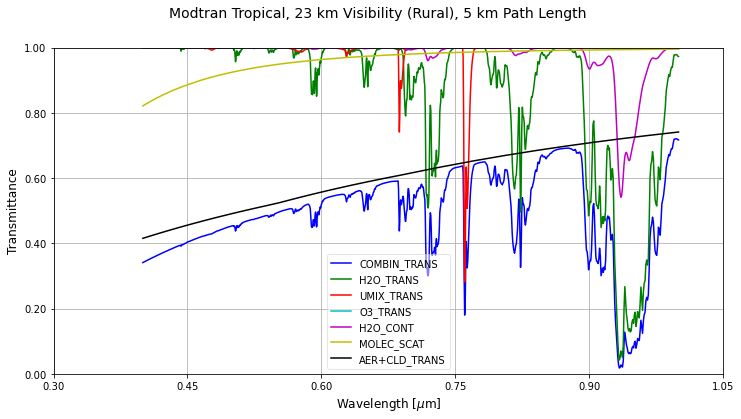

In [8]:
# to plot different contributions to total transmittance.
colSelect =  ['FREQ_CM-1', 'COMBIN_TRANS', 'H2O_TRANS', 'UMIX_TRANS',
              'O3_TRANS', 'H2O_CONT', 'MOLEC_SCAT', 'AER+CLD_TRANS']
tape7= rymodtran.loadtape7("tape7VISNIR5kmTrop23Vis", colSelect )
wavelen = ryutils.convertSpectralDomain(tape7[:,0],  type='nl')
mT = ryplot.Plotter(1, 1, 1,"Modtran Tropical, 23 km Visibility (Rural)"
                   + ", 5 km Path Length",figsize=(12,6))
mT.plot(1, wavelen, tape7[:,1:], "","Wavelength [$\mu$m]", "Transmittance",
       label=colSelect[1:],legendAlpha=0.5, pltaxis=[0.4,1, 0, 1]);


The next example plots the transmittance from the individual molecules and aerosol separately to clearly show the effect of each.


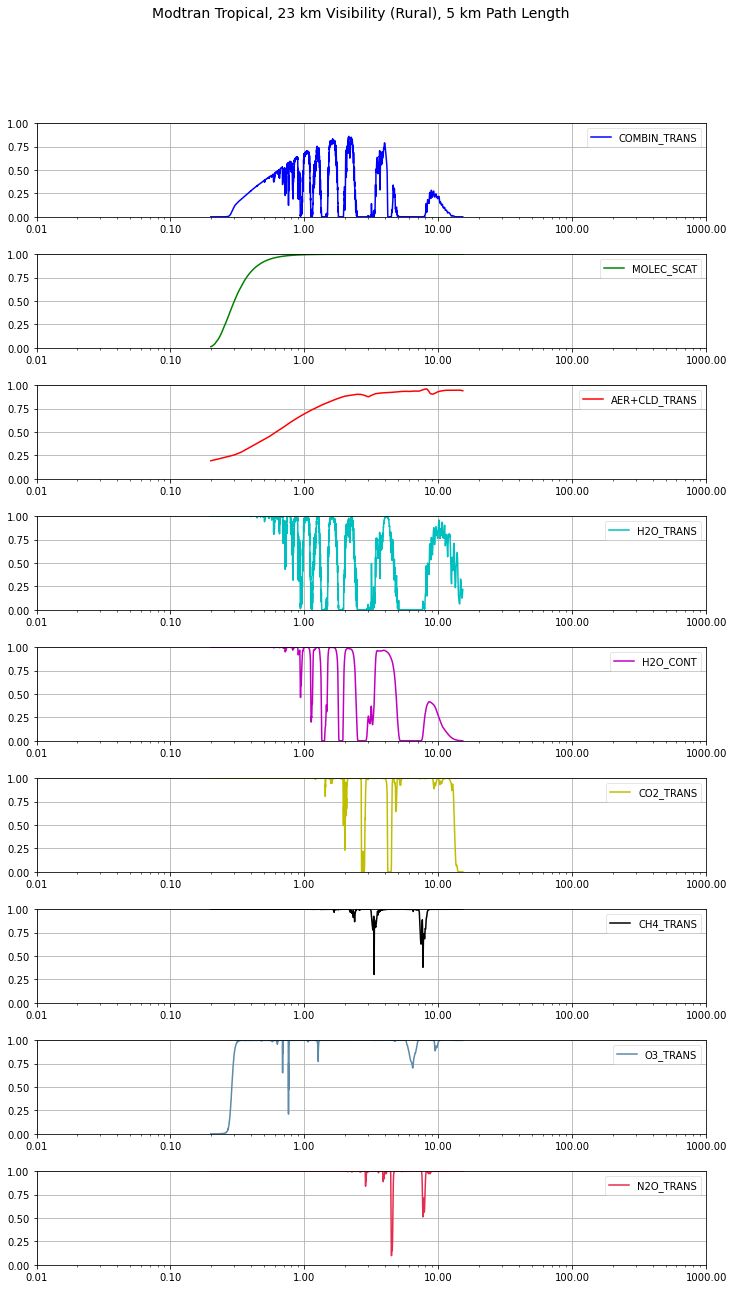

In [9]:
# to plot the individual transmittance components.
colSelect =  ['FREQ_CM-1', 'COMBIN_TRANS', 'MOLEC_SCAT', 'CO2_TRANS', 
              'H2O_TRANS', 'H2O_CONT', 'CH4_TRANS', 'O3_TRANS', 'O2_TRANS', 
              'N2O_TRANS', 'AER+CLD_TRANS', 'SO2_TRANS']
tape7= rymodtran.loadtape7("horizon5kmtropical.fl7", colSelect )
wavelen = ryutils.convertSpectralDomain(tape7[:,0],  type='nl')
mT = ryplot.Plotter(1, 9, 1,"Modtran Tropical, 23 km Visibility (Rural)"                   + ", 5 km Path Length",figsize=(12,21))
mT.semilogX(1, wavelen, tape7[:,1], '','', '', maxNY=4,
       label=colSelect[1:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(2, wavelen, tape7[:,2], '','', '', maxNY=4,
       label=colSelect[2:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(3, wavelen, tape7[:,10], '','', '', maxNY=4,
       label=colSelect[10:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(4, wavelen, tape7[:,4] , '','', '', maxNY=4,
       label=colSelect[4:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(5, wavelen, tape7[:,5] , '','', '', maxNY=4,
       label=colSelect[5:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(6, wavelen, tape7[:,3]  , '','', '', maxNY=4,
       label=colSelect[3:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(7, wavelen, tape7[:,6]  , '','', '', maxNY=4,
       label=colSelect[6:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(8, wavelen, tape7[:,7] * tape7[:,8] , '','', '', maxNY=4,
       label=colSelect[7:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(9, wavelen, tape7[:,9]  , '','', '', maxNY=4,
       label=colSelect[9:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);


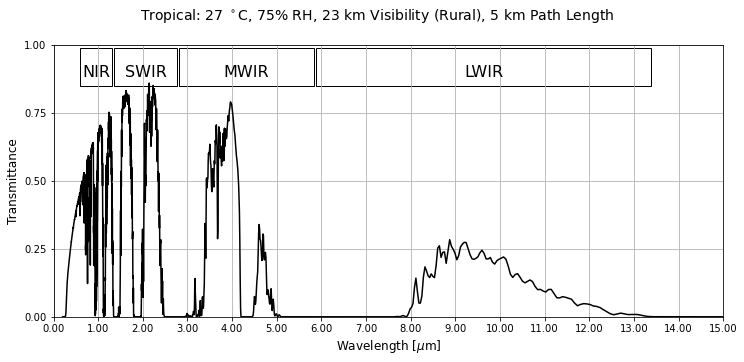

In [10]:
# to plot an annotated graph showing band definitions.
import matplotlib.patches as patches
colSelect =  ['FREQ_CM-1', 'COMBIN_TRANS']
tape7= rymodtran.loadtape7("horizon5kmtropical.fl7", colSelect )
wavelen = ryutils.convertSpectralDomain(tape7[:,0],  type='nl')
mT = ryplot.Plotter(1, 1, 1,"Tropical: 27 $^\circ$C, 75% RH, 23 km Visibility (Rural)"
                    + ", 5 km Path Length",
                    figsize=(12,5),doWarning=False)
mT.plot(1, wavelen, tape7[:,1], '','Wavelength [$\mu$m]', 'Transmittance', maxNY=4,maxNX=15,
       legendAlpha=0.5, pltaxis=[0.2,15, 0, 1],plotCol=['k']);


ax = mT.getSubPlot(1)
for txt,tp in zip(['NIR','SWIR','MWIR','LWIR'],[(0.04,.048),(0.09,.095),(0.187,.2025),(0.392,.5)]):
    p = patches.Rectangle((tp[0],.85),tp[1],.14,fill=True,color='white',transform=ax.transAxes, clip_on=False)
    p.set_edgecolor('black')
    ax.add_patch(p)
    ax.annotate(txt, xy=(tp[0]+tp[1]/2,.9),  xycoords='axes fraction', fontsize=16,
            horizontalalignment='center', verticalalignment='center')
mT.saveFig('atmosphere2.pdf')

The final example reads path radiance data from a file, plots the results, and calculates the total path radiance in a spectral band.  In this example the plot and integration are done in wavenumber domain. Normally you would multiply with a sensor spectral response before integration, but this calculation is over the whole band, equally weighted.

The \ac{MODTRAN} path radiance must be converted to metre-based units, see the introduction above.


PTH_THRML integral is 9.4787611806e-18 [W/(m^2.sr)]
THRML_SCT integral is 9.27772467445e-18 [W/(m^2.sr)]
SOL_SCAT integral is 0.605931118 [W/(m^2.sr)]
SING_SCAT integral is 0.529447243 [W/(m^2.sr)]
TOTAL_RAD integral is 0.605931118 [W/(m^2.sr)]
Note that multiple scatter contributes significantly to total path radiance


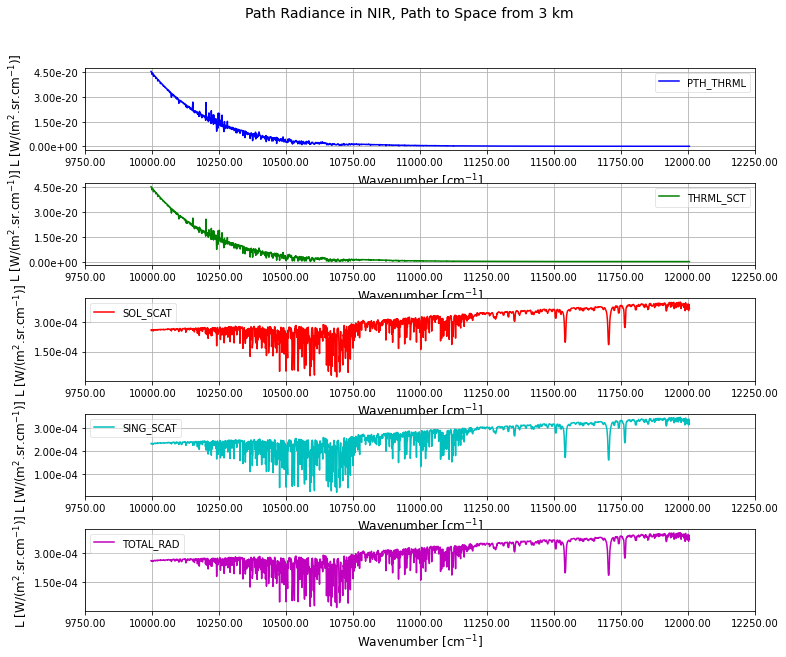

In [11]:
# to plot different contributions to total path radiance on wavenumber scale.

colSelect =  ['FREQ', 'PTH_THRML','THRML_SCT','SOL_SCAT','SING_SCAT', 'TOTAL_RAD']
skyrad= rymodtran.loadtape7("NIRscat.fl7", colSelect )
sr = ryplot.Plotter(1, 5,1,"Path Radiance in NIR, Path to Space from 3 km",
                    figsize=(12,10))
# plot the components separately
for i in [1,2,3,4,5]:
    Lpath = 1.0e4 * skyrad[:,i]
    sr.plot(i,  skyrad[:,0], Lpath, "","Wavenumber [cm$^{-1}$]",
          "L [W/(m$^2$.sr.cm$^{-1}$)]",
         label=[colSelect[i][:]],legendAlpha=0.5, #pltaxis=[0.4,1, 0, 1],
         maxNX=10, maxNY=4, powerLimits = [-4,  4, -5, 5],yAxisFmt='%.2e');

    #convert from /cm^2 to /m2 and integrate using the wavenumber vector
    totinband = np.trapz(Lpath.reshape(-1, 1),skyrad[:,0], 
                                  axis=0)[0]
    print('{0} integral is {1} [W/(m^2.sr)]'.format(colSelect[i][:],totinband))

print('Note that multiple scatter contributes significantly' +       ' to total path radiance')


Repeat the previous example, but this time plot and integrate in the wavelength domain. The integrated results should be the same as for the example above.  In this example the wavenumber domain is converted to wavelength domain and the spectral densities are likewise converted.

Note that the domain and densities are simply converted, not resampled. This means that the data is still at constant wavenumber intervals (varying wavelength intervals). This does not pose a problem when plotting, but care must be taken when integrating to tell `trapz` that the x interval is not constant. Note, however that the data is in a sequence of *increasing* wavenumber; that means *decreasing* wavelength, and as a result the integral is negative (negative integration intervals).


PTH_THRML integral is 9.478758997684696e-18 [W/(m^2.sr)]
PTH_THRML integral is 9.478758997684696e-18 [W/(m^2.sr)]
SOL_SCAT integral is 0.6059311254069286 [W/(m^2.sr)]
SING_SCAT integral is 0.52944724898635 [W/(m^2.sr)]
TOTAL_RAD integral is 0.6059311254069286 [W/(m^2.sr)]
Note that multiple scatter contributes significantly to total path radiance


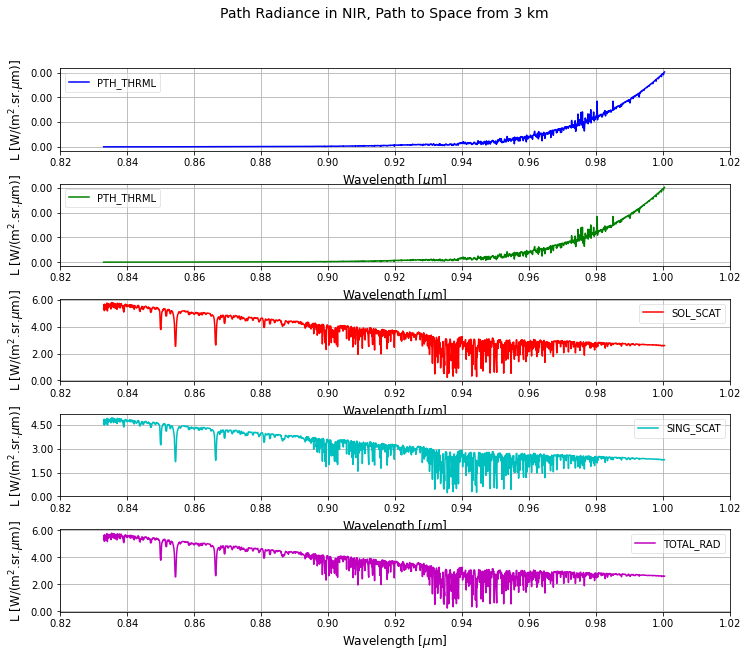

In [12]:
# to plot different contributions to total path radiance on wavelength scale.
colSelect =  ['FREQ', 'PTH_THRML','PTH_THRML','SOL_SCAT','SING_SCAT', 'TOTAL_RAD']
skyrad= rymodtran.loadtape7("NIRscat.fl7", colSelect )
sr = ryplot.Plotter(1, 5,1,"Path Radiance in NIR, Path to Space from 3 km",
                    figsize=(12,10))

# plot the components separately
for i in [1,2,3,4,5]:
    # convert spectral density from wavenumber units to wavelength
    wl, Lpath = ryutils.convertSpectralDensity(skyrad[:,0],skyrad[:,i],'nl')
    # convert cm2 to m2 for area
    Lpath *= 1.0e4
    sr.plot(i,  wl, Lpath, "","Wavelength [$\mu$m]",
          "L [W/(m$^2$.sr.$\mu$m)]",
         label=[colSelect[i][:]],legendAlpha=0.5, #pltaxis=[0.4,1, 0, 1],
         maxNX=10, maxNY=4, powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');

    #convert from /cm^2 to /m2 and integrate using the wavenumber vector
    totinband = - np.trapz(Lpath.reshape(-1, 1),wl, 
                                  axis=0)[0]
    print('{0} integral is {1} [W/(m^2.sr)]'.format(colSelect[i][:],totinband))

print('Note that multiple scatter contributes significantly'
      ' to total path radiance')


Read a file with solar irradiance 

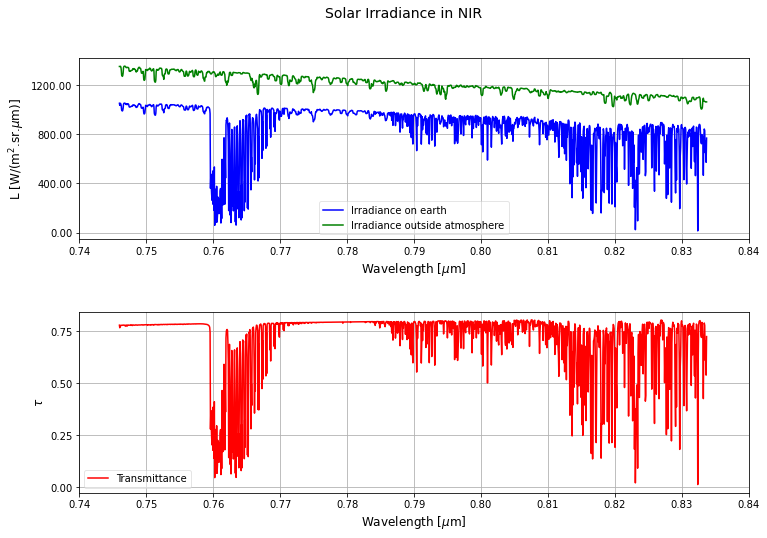

In [13]:
# to plot solar irradiance and total-path-to-space transtmittance.
colSelect =  ['FREQ', 'TRANS','SOL_TR','SOLAR']
sunrad= rymodtran.loadtape7("tape7-sunE", colSelect )

sr = ryplot.Plotter(1,2,1,"Solar Irradiance in NIR", figsize=(12,8))


wl, LsunE = ryutils.convertSpectralDensity(sunrad[:,0],sunrad[:,2],'nl')
wl, LsunS = ryutils.convertSpectralDensity(sunrad[:,0],sunrad[:,3],'nl')

LsunE *= 1.0e4
LsunS *= 1.0e4

sr.plot(1,  wl, LsunE, "","Wavelength [$\mu$m]",
          "L [W/(m$^2$.sr.$\mu$m)]",
         label=['Irradiance on earth'],legendAlpha=0.5, #pltaxis=[0.4,1, 0, 1],
         maxNX=10, maxNY=4, powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');
sr.plot(1,  wl, LsunS, "","Wavelength [$\mu$m]",
          "L [W/(m$^2$.sr.$\mu$m)]",
         label=['Irradiance outside atmosphere'],legendAlpha=0.5, #pltaxis=[0.4,1, 0, 1],
         maxNX=10, maxNY=4, powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');

sr.plot(2,  wl, sunrad[:,1], "","Wavelength [$\mu$m]",
          "$\\tau$",
         label=['Transmittance'],legendAlpha=0.5, #pltaxis=[0.4,1, 0, 1],
         maxNX=10, maxNY=4, powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');


## Nd:YAG Investigation

Path length is 5 \si{\kilo\metre}, for ground level at 1.4 \si{\kilo\metre} and path altitude of 1.8 \si{\kilo\metre}.
The conditions are the Tropical climate model and Desert aerosol (wind speed 18 m/s).

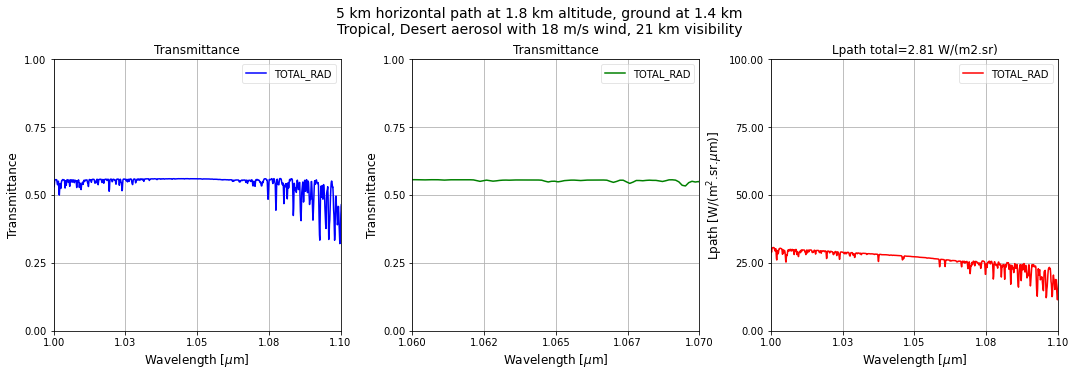

In [37]:
###
colSelect =  ['FREQ', 'TOTAL_RAD','TOT_TRANS']
tape7 = rymodtran.loadtape7("data/NdYAG/20210914-EOCourse.tp7", colSelect )
sr = ryplot.Plotter(1,1,3,"5 km horizontal path at 1.8 km altitude, ground at 1.4 km"
            "\nTropical, Desert aerosol with 18 m/s wind, 21 km visibility", figsize=(18,5))

# convert spectral density from wavenumber units to wavelength
wl, Lpath = ryutils.convertSpectralDensity(tape7[:,0],tape7[:,1],'nl')
# convert cm2 to m2 for area
Lpath *= 1.0e4
# integrate over spectral, note use of wl to get good dx values
totinband = - np.trapz(Lpath.reshape(-1, 1),wl, axis=0)[0]

sr.plot(1,  wl, tape7[:,2], f"Transmittance",
        "Wavelength [$\mu$m]","Transmittance",pltaxis=[1,1.1, 0, 1],
        label=[colSelect[1][:]],legendAlpha=0.5, maxNX=5, maxNY=4, 
        powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');
sr.plot(2,  wl, tape7[:,2], f"Transmittance",
        "Wavelength [$\mu$m]","Transmittance",pltaxis=[1.06,1.07, 0, 1],
        label=[colSelect[1][:]],legendAlpha=0.5, maxNX=5, maxNY=4, 
        powerLimits = [-4,  4, -5, 5],xAxisFmt='%.3f');
sr.plot(3,  wl, Lpath, f"Lpath total={totinband:.2f} W/(m2.sr)",
        "Wavelength [$\mu$m]","Lpath [W/(m$^2$.sr.$\mu$m)]",pltaxis=[1,1.1,0,100],
        label=[colSelect[1][:]],legendAlpha=0.5, maxNX=5, maxNY=4, 
        powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');


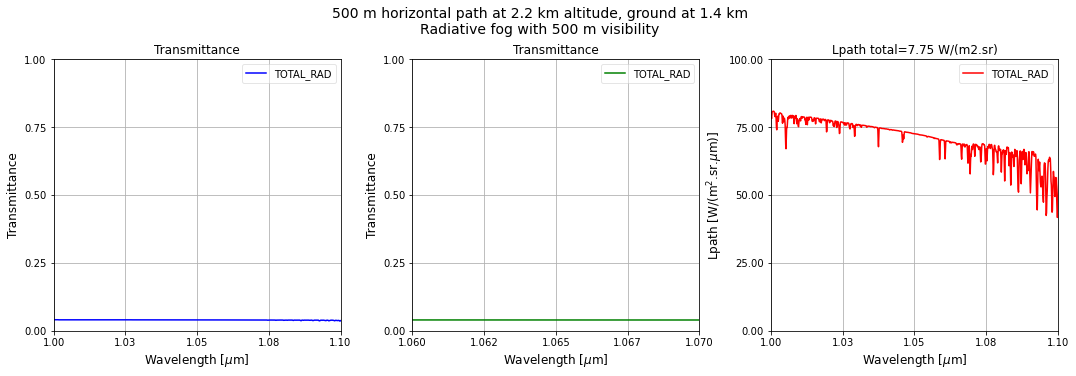

In [38]:
###
colSelect =  ['FREQ', 'TOTAL_RAD','TOT_TRANS']
tape7 = rymodtran.loadtape7("data/NdYAG/20210914-EOCourseFog.tp7", colSelect )
sr = ryplot.Plotter(1,1,3,"500 m horizontal path at 2.2 km altitude, ground at 1.4 km"
            "\nRadiative fog with 500 m visibility", figsize=(18,5))

# convert spectral density from wavenumber units to wavelength
wl, Lpath = ryutils.convertSpectralDensity(tape7[:,0],tape7[:,1],'nl')
# convert cm2 to m2 for area
Lpath *= 1.0e4
# integrate over spectral, note use of wl to get good dx values
totinband = - np.trapz(Lpath.reshape(-1, 1),wl, axis=0)[0]

sr.plot(1,  wl, tape7[:,2], f"Transmittance",
        "Wavelength [$\mu$m]","Transmittance",pltaxis=[1,1.1, 0, 1],
        label=[colSelect[1][:]],legendAlpha=0.5, maxNX=5, maxNY=4, 
        powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');
sr.plot(2,  wl, tape7[:,2], f"Transmittance",
        "Wavelength [$\mu$m]","Transmittance",pltaxis=[1.06,1.07, 0, 1],
        label=[colSelect[1][:]],legendAlpha=0.5, maxNX=5, maxNY=4, 
        powerLimits = [-4,  4, -5, 5],xAxisFmt='%.3f');
sr.plot(3,  wl, Lpath, f"Lpath total={totinband:.2f} W/(m2.sr)",
        "Wavelength [$\mu$m]","Lpath [W/(m$^2$.sr.$\mu$m)]",pltaxis=[1,1.1,0,100],
        label=[colSelect[1][:]],legendAlpha=0.5, maxNX=5, maxNY=4, 
        powerLimits = [-4,  4, -5, 5],xAxisFmt='%.2f');


## Range scaling atmospheric transmittance and path radiance 

If the spectral transmittance at one range is known, it can be scaled to other distances by applying Beer/Bouguer's law.
Calculate the attenuation coefficient for the known transmittance and then apply it to other distances.
$$
\tau_a(R_1) = \exp(-R_1 \alpha_a)
$$
$$\alpha_a = -\log(\tau_a(R_1))/R_1
$$
and then calculate the transmittance at the required range by 
$$
\tau_a(R) = \exp(-R \alpha_a)
$$

Path radiance can be scaled by multiplication/division by $(1-\tau)$. Divide the known path radiance by  $(1-\tau_\textrm{known})$ and then multiply with $(1-\tau_\textrm{new})$. The path radiance for an infinitely long path can be calculated and then rescaled:

$$
L_\textrm{path}(R\rightarrow \infty)
=
\frac{L_\textrm{path1}}{1-\tau_\textrm{path1}}
=
\frac{L_\textrm{path2}}{1-\tau_\textrm{path2}}
$$


\ac{MODTRAN} was used to calculate path radiance and transmittance for several distances, using the same atmospheric model. The path is horizontal, at sea level. The Tropical climate model is used with a Rural aerosol and 23 km visibility.

In [ ]:
# to demonstrate recaling transmittance from one range to another.
pranges = [100,1000,10000]

p = ryplot.Plotter(1,2,2,figsize=(16,8))
for prange in pranges:
    colsPath = ['FREQ', 'TOT_TRANS', 'TOTAL_RAD','DEPTH']
    tape7 = rymodtran.loadtape7(f"data/path{prange}/tape7", colsPath)
    dfPath = pd.DataFrame(tape7,columns=colsPath)
    dfPath = dfPath.rename(columns={'FREQ': 'nu','TOT_TRANS':'tauPath','TOTAL_RAD':'radPathNu'})
    wlp, dfPath['radPathWl'] = ryutils.convertSpectralDensity(dfPath['nu'].values,dfPath['radPathNu'].values,'nl')
    dfPath['radPathWl'] *= 1.0e4
    dfPath['tauPath'] += 1e-6 # prevent zero transmittance
    
    dfPath['wl'] = 1e4 / dfPath['nu']
#     dfPath['alphaP'] = -np.log(dfPath['tauPath']) / prange
    dfPath['alphaP'] = dfPath['DEPTH'] / prange
    
    dfPath['radPathWlNorm'] = dfPath['radPathWl'] / (1 - dfPath['tauPath'] )
#     print(dfPath[dfPath['tauPath']<0.01])
    p.plot(1,dfPath['wl'],dfPath['radPathWl'],'Path radiance over distance','Wavelength [$\mu$m]','Radiance W/(m2.sr.um)', 
           xAxisFmt='%.2f',label=[f'{prange} m'])
    p.plot(2,dfPath['wl'],dfPath['tauPath'],'Path transmittance over distance','Wavelength [$\mu$m]','Transmittance',
           xAxisFmt='%.2f',label=[f'{prange} m'])
    p.plot(3,dfPath['wl'],dfPath['radPathWlNorm'],'Path radiance / (1-$\\tau$)','Wavelength [$\mu$m]','Radiance W/(m2.sr.um)',
           xAxisFmt='%.2f',label=[f'{prange} m'])
    p.semilogY(4,dfPath['wl'],dfPath['alphaP'],'Path attentuation coefficient','Wavelength [$\mu$m]','Attenuation [1/m]', 
           xAxisFmt='%.2f',label=[f'{prange} m'])


The bottom-left graph indicates that path radiance can be accurately re-calculated for different distances, 

It is evident from the bottom-right graph that the attenuation coefficient approximation is not quite valid to scale for range in strong attenuation lines.  The \ac{MODTRAN} documentation also mentions somewhere that transmittance at closer ranges is less accurate than at longer ranges.

In spectroscopy the deviations (called nonlinearity errors) from Beer's law is well studied and documented.  There are several causes identified most of which is relevant to spectroscopy only (instrument functions, chemical interactions, and what we call path radiance).  One cause that could apply here in a modified form is that attenuation decreases at higher concentrations of molecules. At higher concentration (number of molecules along the path?) 
there is interaction between absorbing particles such that the absorption decreases.

The decreased absorption for longer paths is evident in the bottom-right graph. Note that the difference only occurs in the molecular lines (oxygen in this case). A wavelengths with no molecular absorption, Beer's law holds well.  Extending the interaction argument this also means that the effect will be more pronounced for stronger absorbing molecules, such as the oxygen shown here or CO_\textsubscript{2} at 4.3 $\mu$m.

Suppose that the 1000~m transmittance is used as the baseline, then transmittance  estimates at  shorter distances  will be higher than if calculated directly.  Conversely transmittance at longer wavelengths will be lower than if calculated directly.

See these sources \cite{WikipediaBeerLambertlaw2021,Mayerhofer2020,Efstathiou2021}


## Python and module versions, and dates

In [ ]:
# to show Python versions.
try:
    import pyradi.ryutils as ryutils
    print(ryutils.VersionInformation('matplotlib,numpy,pyradi,scipy,pandas'))
except:
    print("pyradi.ryutils not found")